In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (12, 10)
import numpy as np
import pandas as pd
import copy

For testing let's task R101 from VRPTW benchmark: http://web.cba.neu.edu/~msolomon/problems.htm.

In [2]:
df = pd.read_csv('r101.csv', sep=',')
df = df.head(25)

In [3]:
df.head()

,CUST,XCOORD,YCOORD,DEMAND,READYTIME,DUEDATE,SERVICETIME
0,1,35.0,35.0,0.0,0.0,230.0,0.0
1,2,41.0,49.0,10.0,161.0,171.0,10.0
2,3,35.0,17.0,7.0,50.0,60.0,10.0
3,4,55.0,45.0,13.0,116.0,126.0,10.0
4,5,55.0,20.0,19.0,149.0,159.0,10.0


- CUST -- customer number
- XCOORD -- X coordinate of the customer
- YCOORD -- Y coordinate of the customer
- DEMAND -- customer's demand
- READYTIME -- service time
- DUEDATE -- latest service time
- SERVICETIME -- request service time (0.0 for static customer)

In [4]:
VEHICLE_CAPACITY = 200
DEPOT = pd.Series({'XCOORD': 0.0, 'YCOORD': 0.0, 'READYTIME': 0.0, 'DUEDATE': 0.0})

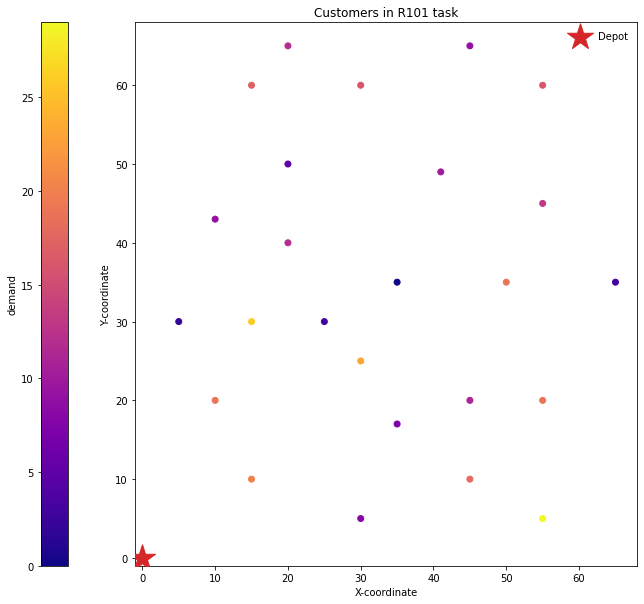

In [5]:
# let's plot the customers and the depot
fig, ax = plt.subplots()
axp = ax.scatter(df["XCOORD"], df["YCOORD"], c=df["DEMAND"], cmap='plasma')
ax.scatter(DEPOT["XCOORD"], DEPOT["YCOORD"], c="tab:red", label="Depot", zorder=3, marker="*", s=750)
cb = plt.colorbar(axp,ax=[ax],location='left')
cb.ax.set_ylabel("demand")
ax.set_title("Customers in R101 task")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_xlim(left=-1)
ax.set_ylim(bottom=-1)
ax.legend(frameon=False, ncol=3)

First, we create the solution state.

In [6]:
# solution class
class DVRPTWState:
    """
    Solution state for DVRP.
    Attributes:
        routes: A list of list of integers, where each inner list corresponds to a single route denoting the sequence of customers to be visited. A route does not contain the depot.
        removal: A list of integers, each integer representing a customer in a removal list.
    """
    def __init__(self, routes, removal=None):
        self.routes = routes
        self.removal = removal if removal is not None else []
    
    def copy(self):
        return DVRPTWState(copy.deepcopy(self.routes), self.removal.copy())
    
    def objective(self):
        """
        Computes the total route cost.
        """
        return sum(route_cost(route) for route in self.routes)
    
    @property
    def cost(self):
        """
        Alias for objective method. Used for plotting.
        """
        return self.objective()
    
    def find_route(self, customer):
        """
        Return the route that contains the passed-in customer.
        """
        for route in self.routes:
            if customer in route:
                return route
        raise ValueError(f"Solution does not contain customer {customer}")


def distance(node1, node2):
    return np.sqrt((node1["XCOORD"].item() - node2["XCOORD"].item()) ** 2 + (node1["YCOORD"].item() - node2["YCOORD"].item()) ** 2)


def route_cost(route):
    tour = [DEPOT] + [df[df.CUST == x] for x in route] + [DEPOT]
    return sum(distance(tour[i], tour[i+1]) for i in range(len(tour) - 1))

In [7]:
def plot_solution(solution, name="DVRPTW Solution"):
    """
    Plot the routes of the passed-in solution.
    """
    fig, ax = plt.subplots()
    cmap = matplotlib.cm.rainbow(np.linspace(0, 1, len(solution.routes)))

    for idx, route in enumerate(solution.routes):
        ax.plot(
            [0] + [df[df.CUST == loc].XCOORD.item() for loc in route] + [0],
            [0] + [df[df.CUST == loc].YCOORD.item() for loc in route] + [0],
            color=cmap[idx],
            marker='.'
        )

    ax.scatter(DEPOT["XCOORD"], DEPOT["YCOORD"], c="tab:red", label="Depot", zorder=3, marker="*", s=750)


    ax.set_title(f"{name}\nTotal distance: {solution.cost}\nNumber of routes: {len(solution.routes)}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)

Next, let's specify the initial solution that builds a solution out of static customers. This solution will be repeatedly destroyed and repaired by the ALNS heuristics.

The algorithm starts with an empty solution and then iteratively adds customers with the least cost to the routes. If there are no routes available, then a new route is added. This algoirthm is simlar to the Nearest Neighbor heuristic.

In [8]:
MU = 1  # a coefficient that controls the relative importance of the travel distance and time constraint
def feasibility_cost(k, i, j):
    """
    The feasibility cost of inserting customer k between customers i and j.
    """
    k_cust = df[df.CUST == k]
    i_cust = df[df.CUST == i]
    j_cust = df[df.CUST == j]
    if i == 0:
        i_cust = DEPOT
    if j == 0:
        j_cust = DEPOT
    
    # Check time feasibility
    if i_cust.READYTIME.item() > k_cust.READYTIME.item() and i_cust.DUEDATE.item() >= k_cust.DUEDATE.item():
        return None
    if (j_cust.READYTIME.item() < k_cust.READYTIME.item() and j_cust.DUEDATE.item() <= k_cust.DUEDATE.item()) and j_cust.READYTIME.item() > 0:
        return None

    # Extra travel distance caused by insertion of k
    d_ikj = distance(i_cust, k_cust) + distance(k_cust, j_cust) - distance(i_cust, j_cust)
    # Delay of the service start time of j after inserting k
    t_ikj = 0  # not sure, how to calculate the delay: b' - b in the article, what is b'?
    return MU * d_ikj + (1 - MU) * t_ikj

def least_cost(removal, route):
    """
    Return the customers and their best positions with the least cost of insertion into the route, excluding the depot.
    """
    cust_pos_cost = []  # in form of [(k, i, cost), ...] where k is the customer to insert, i is the index of the customer in route after which to insert, cost is the cost of insertion
    for cust in removal:
        # For each customer calculate feasibility cost of insertion between adjacent customers i and i+1 in the route (on position i+1) + edge
        costs = [feasibility_cost(cust, route[i], route[i+1]) for i in range(len(route)-1)] + [feasibility_cost(cust, route[-1], 0)]
        costs = [cost for cost in costs if cost is not None]
        i = np.argmin(costs)
        min_cost = costs[i]
        cust_pos_cost.append((cust, i+1, min_cost))  # on position i+1!
    return sorted(cust_pos_cost, reverse=True, key=lambda x: x[2])

def seed(removal, type="farthest"):
    """
    Return the seed customer from removal list who is farthest from the depot or has the earliest deadline of service.
    """
    if type == "farthest":
        return max(removal, key=lambda x: distance(DEPOT, df[df.CUST == x]))
    elif type == "earliest":
        return min(removal, key=lambda x: df[df.CUST == x].DUEDATE.item())
    else:
        raise ValueError(f"Wrong type for seed customer evaluation: {type}")

def init_sol():
    """
    Build initial solution by iteratively constructing routes, where the customer with the least cost is added until the route has met the vehicle capacity limit.
    """
    routes = []
    removal = set(df["CUST"])

    while removal:
        # Start at the depot
        route = [0]
        route_demands = 0

        # And add seed customer
        seed_cust = seed(removal)
        route.append(seed_cust)
        route_demands += df[df.CUST == seed_cust].DEMAND.item()
        removal.remove(seed_cust)

        while removal:
            # Add the least costly customer to the route until max capacity
            nearest, nearest_pos, _ = least_cost(removal, route)[0]

            if route_demands + df[df.CUST == nearest].DEMAND.item() > VEHICLE_CAPACITY:
                break

            route.insert(nearest_pos, nearest)
            removal.remove(nearest)
            route_demands += df[df.CUST == nearest].DEMAND.item()
        
        customers = route[1:]  # remove the depot
        routes.append(customers)
    
    return DVRPTWState(routes)


In [9]:
init = init_sol()

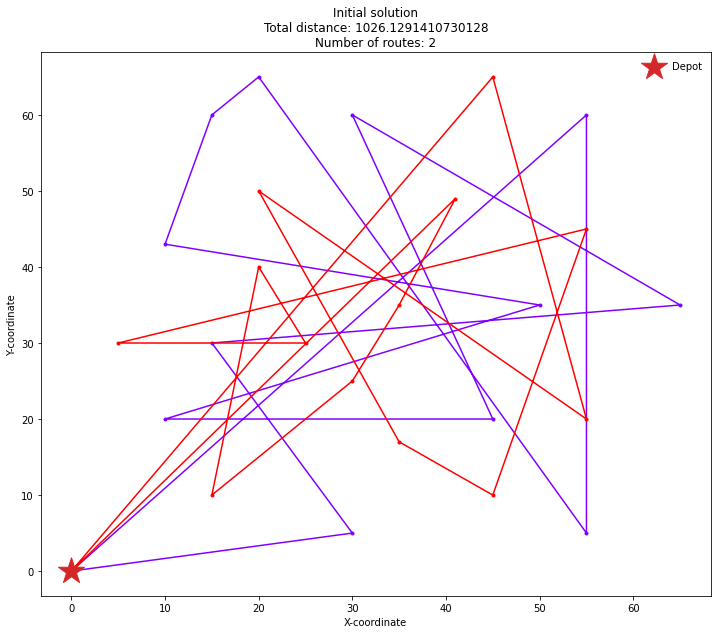

In [10]:
plot_solution(init, "Initial solution")

# Destroy Solution

In [11]:
from functools import reduce

In [12]:
def random_removal(solution, enroute, params):
    return [(c,v) for c,v in zip(list(enroute), np.random.random(size=len(enroute)))]

def worst_removal(solution, enroute, params):
    score = []
    for c in enroute:
        route = solution.find_route(c)
        route_ww = route[::]
        route_ww.remove(c)
        score.append((c, -(route_cost(route) - route_cost(route_ww))))
    return score

def static_rel_removal(solution, enroute, params):
    if solution.removal:
        ref = np.random.choice(list(solution.removal))
    else:
        ref = np.random.choice(list(enroute))
    
    node_ref = df[df.CUST == ref].iloc[0]
    score = []
    for c in enroute:
        node_c = df[df.CUST == c].iloc[0]
        D = distance(node_ref, node_c)
        T = np.abs(node_ref.DUEDATE - node_c.DUEDATE)
        score.append((c, params['alpha'] * D / params['M_D'] + params['beta'] * T / params['M_T']))
    return score


def time_rel_removal(solution, enroute, params):
    raise NotImplementedError("Нужно слишком много новых параметров")

In [13]:
def destroy_solution(solution, destroy_score_fn, params):
    del_sol = solution.copy()
    del_sol.removal = set(del_sol.removal)
    enroute = reduce(lambda x, y: x | y, [set(r) for r in del_sol.routes], set()) # TODO: Add to solution class

    while len(del_sol.removal) < params['q']:
        scores = sorted(destroy_score_fn(del_sol, enroute, params), key=lambda x: x[1])
        z = np.random.random()
        i = int((z ** params['d']) * len(enroute))
        del_sol.removal.add(scores[i][0])
        del_sol.find_route(scores[i][0]).remove(scores[i][0])
        enroute.remove(scores[i][0])
    
    del_sol.removal = list(del_sol.removal)
    return del_sol

In [14]:
params = dict(
    q=3,
    alpha=1,
    M_D=1,
    M_T=1,
    beta=1,
    d=8,
)
sol = destroy_solution(init, static_rel_removal, params)

In [15]:
init.routes, init.removal

([[16, 6, 25, 11, 22, 17, 13, 9, 20, 12, 24, 10],
  [2, 1, 14, 15, 19, 7, 18, 4, 23, 3, 8, 5, 21]],
 [])

In [16]:
sol.routes, sol.removal

([[16, 6, 25, 11, 22, 17, 13, 20, 12, 24, 10],
  [2, 1, 14, 15, 18, 4, 23, 3, 8, 5, 21]],
 [9, 19, 7])

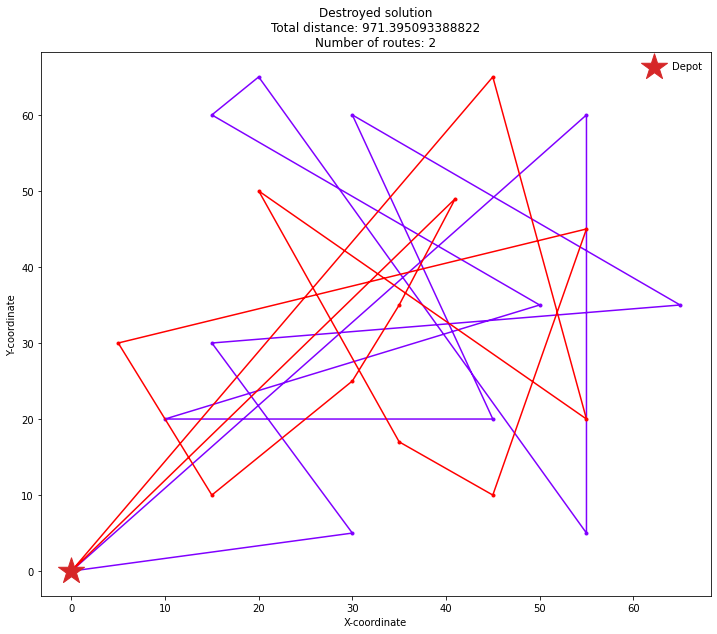

In [17]:
plot_solution(sol, "Destroyed solution")

# Repair Solution

In [18]:
def greedy_insertion(sol: DVRPTWState):
    """
    Greedy Insertion (GI) repair heuristic.
    """
    removal = set(sol.removal)
    rep_sol = sol.copy()
    while removal:
        best_cost = float('inf')
        best_cust, best_route, best_pos = None, None, None
        for cust in removal:
            for r_idx, route in enumerate(rep_sol.routes):
                for pos in range(len(route)):
                    # Calculate the cost of inserting the customer at the current position
                    delta_h = feasibility_cost(cust, route[pos-1], route[pos])
                    if delta_h is not None and delta_h < best_cost:
                        best_cost = delta_h
                        best_cust, best_route, best_pos = cust, r_idx, pos
        if best_cust is not None:
            rep_sol.routes[best_route].insert(best_pos, best_cust)
            removal.remove(best_cust)
        else:
            break
    rep_sol.removal = list(removal)
    return rep_sol


def regret_insertion(sol: DVRPTWState, rnd, k=2):
    """
    Regret Insertion (RI) repair heuristic.
    """
    removal = set(sol.removal)
    rep_sol = sol.copy()
    while removal:
        regret_values = []
        for cust in removal:
            best_positions = sorted(list(filter(lambda x: x[2] is not None,
                                    [(r_idx, pos, feasibility_cost(cust, route[pos-1], route[pos]))
                                    for r_idx, route in enumerate(rep_sol.routes)
                                    for pos in range(len(route))])),
                                    key=lambda x: x[2])[:k]
            if len(best_positions) >= 2:
                regret_value = sum(pos[2] for pos in best_positions[1:]) - best_positions[0][2]
                regret_values.append((cust, regret_value, best_positions[0]))

        if regret_values:
            max_regret_cust, _, (r_idx, pos, _) = max(regret_values, key=lambda x: x[1])
            rep_sol.routes[r_idx].insert(pos, max_regret_cust)
            removal.remove(max_regret_cust)
        else:
            break
    rep_sol.removal = list(removal)
    return rep_sol

([[16, 6, 25, 11, 22, 17, 13, 9, 20, 12, 24, 10],
  [2, 1, 14, 15, 19, 7, 18, 4, 23, 3, 8, 5, 21]],
 [])

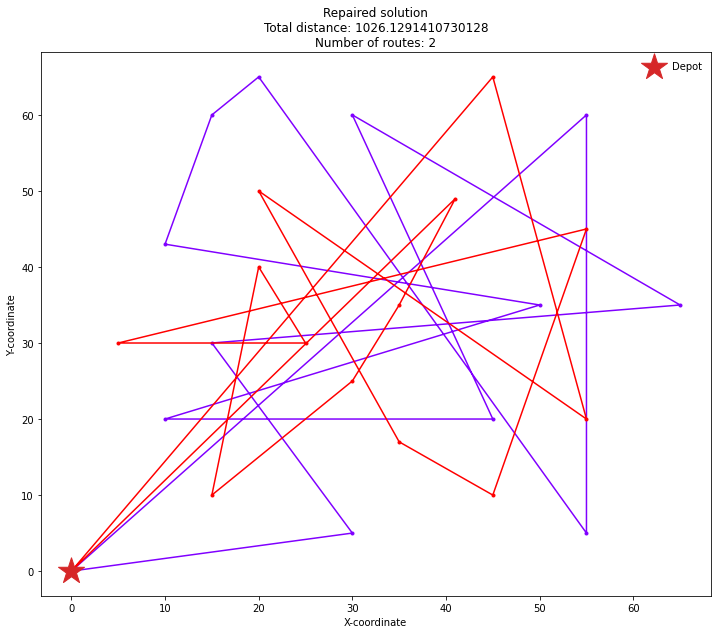

In [19]:
# Call the repair function and update your state
repaired_solution = greedy_insertion(init)
# Plot the solution after applying the repair heuristic

plot_solution(repaired_solution, "Repaired solution")
repaired_solution.routes, repaired_solution.removal